In [1]:
import numpy as np
from numpy import random as rd
from collections import Counter
import matplotlib.pyplot as plt

### Discrete distribution simulator
Using only calls to rd.uniform()
Given a list of n states and their respective probability:
* create n intervals [p_0=0, p_1], [p_1, p_1+p_2], ..., [p_1+p_2+...+p_n-1, 1]
* draw x from the uniform distribution over [0, 1] : there exists a unique i such that p_i-1 <= x < p_i; return state i
* the probability of returning state i is precisely p_i

The index i can found with e.g a binary search in O(log(n))

In [2]:
class RNG():
    def __init__(self, p={}, search='linear'):
        """
        p : dictionary mapping numbers to their probability of being drawn
        """
        self._p = p
        self._search = search
        
        self._p_keys = list(p.keys())
        self._p_values = list(p.values())

        if np.abs(sum(p.values())-1) > 1e-10:
            raise NameError('Sum of probability must be equal to 1')
    
        buckets = []
        cum_p = 0
        for key in p:
            cum_p += p[key]
            buckets.append(cum_p)
        self._buckets = buckets
    
    def single_draw_lin_search(self):
        x = rd.uniform()
        for i, key in enumerate(self._p):
            right = self._buckets[i]
            if( right >= x ):
                return key
        
    def single_draw_bin_search(self):
        """
        Binary search to find the index of the probability bucket
        """
        left, right = 0, len(self._p)
        x = rd.uniform()
        while left<right:
            mid = int((left+right)/2)
            if self._buckets[mid] < x:
                left = mid+1
            else:
                right = mid
        return self._p_keys[left]
    
    def rd_choice(self):
        return rd.choice(self._p_keys, p=self._p_values)
    
    def draw(self, n):
        """
        Draw a independent sample of size n based on probability distribution self._p
        """
        if self._search == 'linear':
            draw_func = self.single_draw_lin_search
        elif self._search == 'binary':
            draw_func = self.single_draw_bin_search
        # benchmark against rd.choice function
        elif self._search == 'rd.choice':
            draw_func = self.rd_choice
        else:
            raise NameError('Unknown search type')
            
        return [ draw_func() for _ in range(int(n))]

### Toy example

In [3]:
p = {
    0.1: 0.2,
    0.2: 0.2,
    0.5: 0.2,
    0.8: 0.2,
    0.9: 0.2,
}

In [4]:
G = RNG(p, search='binary')
[0] + G._buckets

[0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]

In [5]:
G.draw(10)

[0.8, 0.8, 0.9, 0.9, 0.8, 0.1, 0.1, 0.9, 0.1, 0.2]

### Initialize random distribution

In [6]:
def init_random_p(n):
    """
    draw n random points in [0,1] with random probabilities
    """
    p_keys, p_proba = rd.random(n), rd.random(n)
    p_proba = list(np.array(p_proba)/np.sum(p_proba))
    return dict(zip(p_keys, p_proba))

### Test that empirical frequency is same as expected

In [7]:
def single_test(G, n=1e4, verbose=False):
    sample = G.draw(n)
    count = Counter(sample)
    count_p = Counter(G._p)
    err = 0
    for key in count:
        count[key] /= n
        err += np.abs(count[key]-count_p[key])*100
    if verbose:
        print('Mean absolute error : {}%'.format(err))
    return err
    
def test(n_state = 10, n_log_max = 13, n_sim = 100):
    """
    Consider a distribution over n_state points.
    Generate n_sim samples of size 2^n_log, for n_log between 1 and n_log_max
    Compute the average absolute error per simulation (absolute percentage difference
    between empirical frequency and expected probability) then average across simulations
    """
    fig = plt.figure(figsize=(8, 7))
    ax = plt.axes()
    
    p = init_random_p(n_state)
    
    for search in ['linear', 'binary', 'rd.choice' ]:
        G = RNG(p, search=search)
        err = []
        for n_log in range(1, n_log_max+1):    
            err_sim = []
            for _ in range(n_sim):
                err_sim.append(single_test(G, 2 ** n_log))
            err.append(np.mean(err_sim))
        ax.plot(list(range(1, n_log_max+1)), err, label=search)
    
    ax.set_xlabel('Log iterations')
    ax.set_ylabel('Mean absolute error(%)')
    ax.legend()

    plt.tight_layout()
    plt.show()

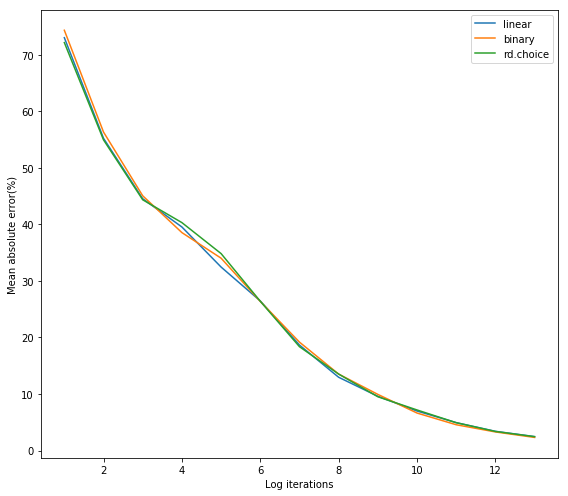

In [8]:
test(n_state=10, n_log_max=13, n_sim=100)

### Compare linear and binary search

In [9]:
n_points=int(1e3)
n_draw = int(1e4)
p = init_random_p(n_points)
G_linear = RNG(p, search='linear')
G_binary = RNG(p, search='binary')
G_rd_choice = RNG(p, search='rd.choice')

In [10]:
%timeit G_linear.draw(n_draw)

665 ms ± 8.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit G_binary.draw(n_draw)

44.7 ms ± 547 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit G_rd_choice.draw(n_draw)

1.35 s ± 42.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
